In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import os

### Load the data set

In [2]:
dataset_dir = "quick_draw_dataset"
files = os.listdir(dataset_dir)
max_size_per_cl = 1500 # We don't want to load the whole database, but only a part.
draw_class = []

# Evaluate the size of the data set
size = 0
for name in files:
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl]
    size += draws.shape[0]

images = np.zeros((size, 28, 28))
targets = np.zeros((size,))

it = 0
t = 0
for name in files:
    # Open each dataset and add a new class
    draw_class.append(name.replace("full_numpy_bitmap_", "").replace(".npy", ""))
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl]
    
    # Add images to the buffer
    images[it:it+draws.shape[0]] = np.invert(draws.reshape(-1, 28, 28))
    targets[it:it+draws.shape[0]] = t
    
    # Iter
    it += draws.shape[0]
    t += 1

# Shuffle dataset

indexes = np.arange(size)
np.random.shuffle(indexes)
images = images[indexes]
targets = targets[indexes]

### Create training and testing datasets

In [3]:
images_train, images_test, targets_train, targets_test = train_test_split(images, targets, test_size = 0.33)

In [4]:
print(images_train.shape, images_test.shape, targets_train.shape, targets_test.shape)

(10050, 28, 28) (4950, 28, 28) (10050,) (4950,)


In [5]:
print(draw_class)

['airplane', 'apple', 'book', 'brain', 'car', 'chair', 'dog', 'eye', 'face', 'The Eiffel Tower']


### Plot examples of images

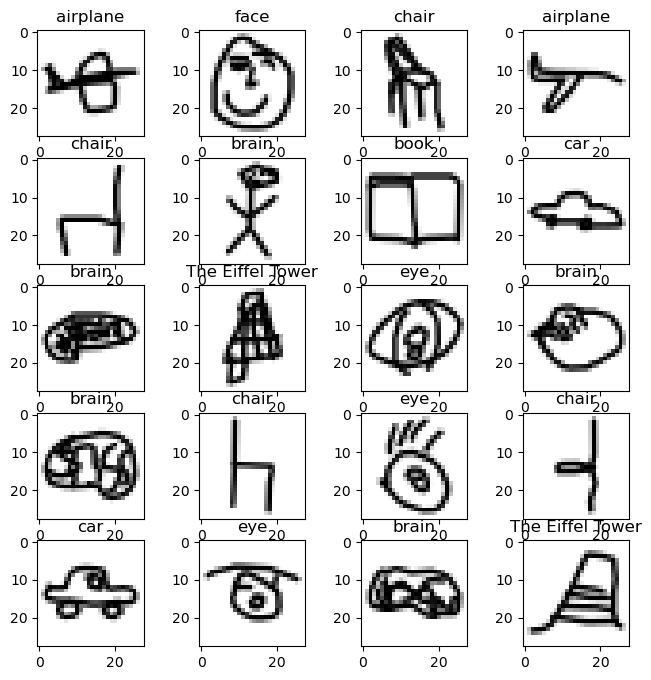

In [6]:
w = 10
h = 10
fig = plt.figure(figsize = (8,8))
columns = 4
rows = 5
for i in range(1, rows*columns+1):
    index = np.random.randint(len(images_train))
    img = images_train[index]
    fig.add_subplot(rows, columns, i)
    plt.title(draw_class[int(targets_train[index])])
    plt.imshow(img, cmap="gray")
plt.show()

### Scaling the data

In [7]:
print("Mean and std of images :", images_train.mean(), images_train.std())

Mean and std of images : 209.42625317291095 85.23342871981295


In [8]:
scaler = StandardScaler()
scaler.fit(images_train.reshape(-1, 28*28))
scaled_images_train = scaler.transform(images_train.reshape(-1, 28*28))
scaled_images_test = scaler.transform(images_test.reshape(-1, 28*28))

scaled_images_train = scaled_images_train.reshape(-1, 28, 28, 1)
scaled_images_test = scaled_images_test.reshape(-1, 28, 28, 1)

In [9]:
print("Mean and std of images :", scaled_images_train.mean(), scaled_images_train.std())

Mean and std of images : 7.899728862395266e-18 0.9285714285714305


### Handle dataset

#### Create the dataset

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_train, targets_train))
test_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_test, targets_test))

#### Iter the dataset

In [11]:
epoch = 1
batch_size = 32
for images_batch, targets_batch in train_dataset.repeat(epoch).batch(batch_size):
    print(images_batch.shape, targets_batch.shape)
    break

(32, 28, 28, 1) (32,)


### Subclassing API

In [12]:
class ConvModel(tf.keras.Model):
    
    def __init__(self):
        super(ConvModel, self).__init__()
        
        # We instantiate three convolutions
        self.conv1 = tf.keras.layers.Conv2D(32, 4, activation = "relu", name = "conv1")
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation = "relu", name = "conv2")
        self.conv3 = tf.keras.layers.Conv2D(128, 3, activation = "relu", name = "conv3")
        
        # Flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name = "flatten")
        
        # Dense layers
        self.d1 = tf.keras.layers.Dense(128, activation = "relu", name = "d1")
        self.out = tf.keras.layers.Dense(10, activation = "softmax", name = "output")
    
    def call(self, image):
        conv1 = self.conv1(image)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        
        flatten = self.flatten(conv3)
        
        d1 = self.d1(flatten)
        output = self.out(d1)
        
        return output

model = ConvModel()
model.predict(scaled_images_train[0:1])

1/1 [==============================] - 0s 422ms/step


array([[0.10977284, 0.0868293 , 0.11040258, 0.09517148, 0.09751641,
        0.09896196, 0.09884828, 0.10452017, 0.09430481, 0.10367213]],
      dtype=float32)

### Set the loss and objectives

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

### Set some metrics to track the progress during training

In [14]:
train_loss = tf.keras.metrics.Mean(name = "train_loss")
valid_loss = tf.keras.metrics.Mean(name = "test_loss")

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = "train_accuracy")
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = "test_accuracy")

## Training method

In [15]:
@tf.function
def train_step(images, targets):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(targets, predictions)

In [16]:
@tf.function
def valid_step(images, targets):
    predictions = model(images)
    t_loss = loss_object(targets, predictions)
    valid_loss(t_loss)
    valid_accuracy(targets, predictions)

## Training

In [18]:
number_of_epochs = 5
batch_size = 32
b = 0
for epoch in range(number_of_epochs):
    # Training set
    for images_batch, targets_batch in train_dataset.batch(batch_size):
        train_step(images_batch, targets_batch)
        template = "\r Batch {}/{}, loss: {}, accuracy: {}"
        print(template.format(b, len(targets), train_loss.result(), train_accuracy.result()*100), end="")
        
        b += batch_size
    
    # Validation set
    for images_batch, targets_batch in test_dataset.batch(batch_size):
        valid_step(images_batch, targets_batch)
        
    template = "Epoch {}, test loss: {}, test accuracy: {}"
    print(template.format(epoch+1, valid_loss.result(), valid_accuracy.result()*100))
    
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    
    train_loss.reset_states()
    train_accuracy.reset_states()

 Batch 10048/15000, loss: 0.2965327501296997, accuracy: 85.49751281738281Epoch 1, test loss: 0.4054144024848938, test accuracy: 88.22222137451172
 Batch 20128/15000, loss: 0.13758620619773865, accuracy: 95.75124359130862Epoch 2, test loss: 0.510421872138977, test accuracy: 87.2323226928711
 Batch 30208/15000, loss: 0.08660411089658737, accuracy: 97.054725646972662Epoch 3, test loss: 0.6313574314117432, test accuracy: 86.52525329589844
 Batch 40288/15000, loss: 0.05296985059976578, accuracy: 98.238807678222666Epoch 4, test loss: 0.6881749033927917, test accuracy: 86.56565856933594
 Batch 50368/15000, loss: 0.03249296918511391, accuracy: 98.885574340820319Epoch 5, test loss: 0.6983001232147217, test accuracy: 87.81818389892578


In [19]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
